<a href="https://colab.research.google.com/github/aleksejalex/special-octo-engine/blob/main/ZLMA_DU_Gaj_ex11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ZLMAcv - ex11 DU 
(by Aleksej Gaj)


Slide from lecture:

Today's tasks:

* From previous 5 models choose the right one. What will be your approach?
Hint: Find the the simplest suitable model. 

* Interpret your final model. Which variables are independent? 

* Which Method is more successfull, A or B? Which method is more successfull for Large stones? 

* What is the odds ratio of succes if we consider small stone compare to large one?

* Use Logit model for previous data and compare results from Logit model to Poisson model. Is the outcome from the logit model same?

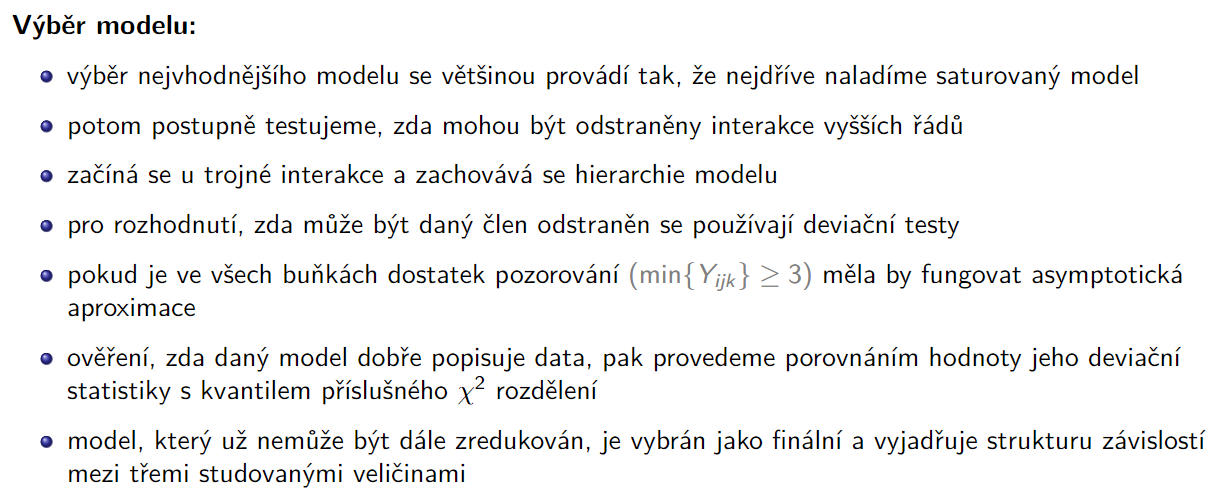

# Installing and importing packages, setting vars

In [28]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
# importy balicku
import inspect
import numpy as np
import scipy as scp
import pandas as pd
import seaborn as sbn
import csv
import matplotlib as mpt
import requests
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt

def retrieve_name(var):
    "vrati nazev promenne jako string"
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

examplevarr = 4
print(examplevarr)
print(retrieve_name(examplevarr))

def gauss(x, mi, sigma2):
    "hustota normalniho rozdeleni. x je bud cislo nebo np.array"
    return (1/(np.sqrt(2*np.pi*sigma2)) * np.exp (-  ( (x-mi)**2 ) / (2*sigma2) ) )


4
['examplevarr']


In [30]:
# additional settings for plotting images:
plt.rcParams.update({"figure.dpi": 130})   # increase DPI, default = 96
#%config InlineBackend.figure_format = "svg"  # every plot (matplotlib's or seaborn's) must be a SVG image

# Data import

In [31]:
import requests

url = 'https://github.com/aleksejalex/special-octo-engine/raw/main/datasets/kstones.rda'
response = requests.get(url)

with open('kstones.rda', 'wb') as f:
    f.write(response.content)

In [32]:
import rpy2.robjects as robjects   # works only on machine that has R installed
import pandas as pd

# Load R data from .rda file
robjects.r['load']('kstones.rda')
r_data = robjects.globalenv['kstones']

# Convert R data to Python OrderedDict
py_data = {k: list(v) for k, v in r_data.items()}

NotImplementedError: ignored

In [34]:
# Convert OrderedDict to pandas dataframe
imported_data = pd.DataFrame.from_dict(py_data)

In [35]:
imported_data

,Counts,Size,Method,Outcome
0,81,2,1,2
1,6,2,1,1
2,234,2,2,2
3,36,2,2,1
4,192,1,1,2
5,71,1,1,1
6,55,1,2,2
7,25,1,2,1


In [36]:
imported_data.describe()

,Counts,Size,Method,Outcome
count,8.000000,8.000000,8.000000,8.000000
mean,87.500000,1.500000,1.500000,1.500000
std,81.900637,0.534522,0.534522,0.534522
min,6.000000,1.000000,1.000000,1.000000
25%,33.250000,1.000000,1.000000,1.000000
50%,63.000000,1.500000,1.500000,1.500000
75%,108.750000,2.000000,2.000000,2.000000
max,234.000000,2.000000,2.000000,2.000000


In [37]:
imported_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Counts   8 non-null      int64
 1   Size     8 non-null      int64
 2   Method   8 non-null      int64
 3   Outcome  8 non-null      int64
dtypes: int64(4)
memory usage: 384.0 bytes


In [38]:
# Vlastne toto na vysledek nema vliv, jen pro pohodli
imported_data['Size'] = pd.factorize(imported_data['Size'])[0] # python faktorizuje tak, ze pro 'yes' vrati 0 a pro 'no' 1, proto opravime:
imported_data['Size'] = np.abs(imported_data['Size'] - 1)
imported_data['Method'] = pd.factorize(imported_data['Method'])[0]
imported_data['Method'] = np.abs(imported_data['Method'] - 1)
imported_data['Outcome'] = pd.factorize(imported_data['Outcome'])[0]
imported_data['Outcome'] = np.abs(imported_data['Outcome'] - 1)

In [39]:
imported_data

,Counts,Size,Method,Outcome
0,81,1,1,1
1,6,1,1,0
2,234,1,0,1
3,36,1,0,0
4,192,0,1,1
5,71,0,1,0
6,55,0,0,1
7,25,0,0,0


## Interpretation of data:

`Size`: Small = 1, Large = 0 \\
`Method`: A = 1, B = 0 \\
`Outcome`: Success = 1, Failure = 0 \\

# Models

### Model ABC - Size, Model, Outcome

In [80]:
model_abc = statsmodels.formula.api.glm(formula='Counts ~ Size + Method + Outcome', data = imported_data, 
                                        family = statsmodels.api.families.Poisson())
results_abc = model_abc.fit()

print(results_abc.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Counts   No. Observations:                    8
Model:                            GLM   Df Residuals:                        4
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -140.58
Date:                Thu, 18 May 2023   Deviance:                       234.44
Time:                        11:59:33   Pearson chi2:                     223.
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5208      0.101     34.926      0.0

### Model (AB,C), i.e. (Size*Method,Outcome)

In [81]:
model_ab_c = statsmodels.formula.api.glm(formula='Counts ~ Size * Method + Outcome', data = imported_data, 
                                         family = statsmodels.api.families.Poisson())
results_ab_c = model_ab_c.fit()

print(results_ab_c.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Counts   No. Observations:                    8
Model:                            GLM   Df Residuals:                        3
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -39.923
Date:                Thu, 18 May 2023   Deviance:                       33.124
Time:                        11:59:33   Pearson chi2:                     31.5
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.7582      0.135     20.379      

### Model (AB,AC), i.e. (Size* Method, Size * Outcome)

In [82]:
model_ab_ac = statsmodels.formula.api.glm(formula='Counts ~ Size * (Method + Outcome)', data = imported_data, 
                                          family = statsmodels.api.families.Poisson())
results_ab_ac = model_ab_ac.fit()

print(results_ab_ac.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Counts   No. Observations:                    8
Model:                            GLM   Df Residuals:                        2
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -25.086
Date:                Thu, 18 May 2023   Deviance:                       3.4503
Time:                        11:59:33   Pearson chi2:                     3.18
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.1086      0.141     21.981   

### Model (AB,AC,BC), i.e. (Size * Method,Size * Outcome, Method * Outcome)

In [83]:
model_ab_ac_bc = statsmodels.formula.api.glm(formula='Counts ~ Size * Method * Outcome - Size:Method:Outcome', data = imported_data, 
                                             family = statsmodels.api.families.Poisson())
results_ab_ac_bc = model_ab_ac_bc.fit()

print(results_ab_ac_bc.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Counts   No. Observations:                    8
Model:                            GLM   Df Residuals:                        1
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.865
Date:                Thu, 18 May 2023   Deviance:                       1.0082
Time:                        11:59:33   Pearson chi2:                    0.962
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.2948      0.178     18.

### Saturated model


In [84]:
model_satur = statsmodels.formula.api.glm(formula='Counts ~ Size * Method * Outcome', data = imported_data, 
                                          family = statsmodels.api.families.Poisson())
results_satur = model_satur.fit()

print(results_satur.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Counts   No. Observations:                    8
Model:                            GLM   Df Residuals:                        0
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.361
Date:                Thu, 18 May 2023   Deviance:                   2.4203e-14
Time:                        11:59:33   Pearson chi2:                 3.78e-20
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.2189    

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


 # Which model is "best"?
 
 Models:

 - `model_satur`
 - `model_abc`
 - `model_ab_ac`
 - `model_ab_ac_bc`
 - `model_ab_c`

In [85]:
list_of_models = [results_abc, results_ab_c, results_ab_ac, results_ab_ac_bc, results_satur]

In [86]:
# constructing dataframe containing all the numbers to conclude which model is the best
results = pd.DataFrame()

#results['model_name'] = [retrieve_name(nm) for nm in list_of_models]  # doesnt work, how to do that in OOP?
results['model_name'] = [retrieve_name(results_abc), retrieve_name(results_ab_c), retrieve_name(results_ab_ac), 
                         retrieve_name(results_ab_ac_bc), retrieve_name(results_satur)]
results['theor_name'] = ["ABC", "AB,C", "AB,AC", "AB,AC,BC", "Satur"]
results['degrees_of_freedom'] = [results_abc.df_resid, results_ab_c.df_resid, results_ab_ac.df_resid, 
                                 results_ab_ac_bc.df_resid, results_satur.df_resid]
results['chi2_test'] = [results_abc.pearson_chi2, results_ab_c.pearson_chi2, results_ab_ac.pearson_chi2, 
                                 results_ab_ac_bc.pearson_chi2, results_satur.pearson_chi2]
#results['p-value'] = []
results['p_value'] = 1 - scp.stats.chi2.cdf(results.chi2_test, results.degrees_of_freedom)

results['deviance'] = [results_abc.deviance, results_ab_c.deviance, results_ab_ac.deviance, 
                                 results_ab_ac_bc.deviance, results_satur.deviance]
results['AIC'] = [results_abc.aic, results_ab_c.aic, results_ab_ac.aic, 
                                 results_ab_ac_bc.aic, results_satur.aic]
results['BIC'] = [results_abc.bic, results_ab_c.bic, results_ab_ac.bic, 
                                 results_ab_ac_bc.bic, results_satur.bic]

results

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


,model_name,theor_name,degrees_of_freedom,chi2_test,p_value,deviance,AIC,BIC
0,[results_abc],ABC,4,2.229994e+02,0.000000e+00,2.344367e+02,289.159233,2.261190e+02
1,[results_ab_c],"AB,C",3,3.151350e+01,6.626702e-07,3.312395e+01,89.846462,2.688562e+01
2,[results_ab_ac],"AB,AC",2,3.176921e+00,2.042398e-01,3.450310e+00,62.172823,-7.085733e-01
3,[results_ab_ac_bc],"AB,AC,BC",1,9.622516e-01,3.266202e-01,1.008164e+00,61.730678,-1.071277e+00
4,[results_satur],Satur,0,3.782240e-20,NaN,2.420282e-14,62.722513,2.420282e-14


In [87]:
results

,model_name,theor_name,degrees_of_freedom,chi2_test,p_value,deviance,AIC,BIC
0,[results_abc],ABC,4,2.229994e+02,0.000000e+00,2.344367e+02,289.159233,2.261190e+02
1,[results_ab_c],"AB,C",3,3.151350e+01,6.626702e-07,3.312395e+01,89.846462,2.688562e+01
2,[results_ab_ac],"AB,AC",2,3.176921e+00,2.042398e-01,3.450310e+00,62.172823,-7.085733e-01
3,[results_ab_ac_bc],"AB,AC,BC",1,9.622516e-01,3.266202e-01,1.008164e+00,61.730678,-1.071277e+00
4,[results_satur],Satur,0,3.782240e-20,NaN,2.420282e-14,62.722513,2.420282e-14


In [88]:
results_satur.converged  # zkonvergoval vubec saturovany model?

True

**AIC:** The Akaike Information Criterion is based on the principle of maximizing the likelihood of the model while penalizing for the number of parameters used. *It takes into account both the goodness of fit and the number of parameters in the model*. **The lower the AIC value, the better the model is considered to be.** AIC does not provide an absolute measure of model quality but is useful for comparing different models and selecting the one with the lowest AIC.

**BIC:** The Bayesian Information Criterion is similar to AIC but takes a more conservative approach by penalizing model complexity more heavily. BIC *incorporates a Bayesian perspective by including a prior probability distribution over the parameters.* Like AIC, **lower BIC values indicate better model fit**, but BIC tends to penalize models with more parameters more severely than AIC. BIC is particularly useful when the goal is to identify the most parsimonious model.


(source: OpenAI. (2021). ChatGPT [Computer software]. Retrieved from https://openai.com )

# Conclusion:

## Which model is the best?


According to table above, model 'AB_AC' can be considered as best regarding all criteria mentioned in the table.

        `A*B + A*C`
        `Counts ~ Size * Method + Size * Outcome`

Since the residual deviance far exceeds the residual degrees of freedom, model 'AB_AC' is the most simple and well describing.

It seems variables `Method` and `Outcome` are independent. 

## Which `Method` is more successfull, A or B? Which method is more successfull for Large stones?

In [49]:
imported_data

,Counts,Size,Method,Outcome
0,81,1,1,1
1,6,1,1,0
2,234,1,0,1
3,36,1,0,0
4,192,0,1,1
5,71,0,1,0
6,55,0,0,1
7,25,0,0,0


In [57]:
data_successes = imported_data[imported_data['Outcome']==1]
data_successes

,Counts,Size,Method,Outcome
0,81,1,1,1
2,234,1,0,1
4,192,0,1,1
6,55,0,0,1


In [62]:
print(81+6+192+71)
print(81+192)
print(234+55+36+25)
print(234+55)

print(289/350)

350
273
350
289
0.8257142857142857


**Method A** (`1`) solved totally $81+6+192+71 = 350$ cases, and only $81+192 = 273$ cases were successfull.

Success rate: $\frac{273}{350} = 0.78 $



**Method B** (`0`) solved totally $234+55+36+25 = 350$ cases, and only $234+55 = 289$ cases were successfull.

Success rate: $\frac{289}{350} ≃ 0.826 $



In [58]:
# which method is better for large stones?
data_large_stones = imported_data[imported_data['Size']==1]
data_large_stones

,Counts,Size,Method,Outcome
0,81,1,1,1
1,6,1,1,0
2,234,1,0,1
3,36,1,0,0


In [56]:
print(81/(81+6))
print(234/(234+36))

0.9310344827586207
0.8666666666666667


From this table we can read that *in case of Large stones* **Method A** (`1`) has successfull rate $ \frac{81}{81+6} ≃ 0.931 $, while **Method B** (`0`) has 
$ \frac{234}{234+36} ≃ 0.867 $

In [50]:
table = pd.crosstab(imported_data['Size'], imported_data['Outcome'])
table

Outcome,0,1
Size,,
0,2,2
1,2,2


Conclusion:

in general, method B was slightly more successfull, but for Large stones Method A appears to be better.

## What is the odds ratio of succes if we consider small stone compare to large one?

In [69]:
imported_data

,Counts,Size,Method,Outcome
0,81,1,1,1
1,6,1,1,0
2,234,1,0,1
3,36,1,0,0
4,192,0,1,1
5,71,0,1,0
6,55,0,0,1
7,25,0,0,0


In [64]:
81+234+6+36

357

In [66]:
192+55+25+71

343

In [67]:
315/357

0.8823529411764706

In [68]:
247/343

0.7201166180758017

If one has **small stones**, he can expect that he will be successfully cured with $p = \frac{315}{357} ≃ 0.882 $.

In case of **Large stones**, the probability is $p = \frac{247}{343} ≃ 0.720 $.

## Use Logit model for previous data and compare results from Logit model to Poisson model. Is the outcome from the logit model same?

We choose model `AB,BC` as the best one (see above). In our variables, it's 

    `A*B + A*C`
    `Counts ~ Size * Method + Size * Outcome`

Now, according to the table provided:



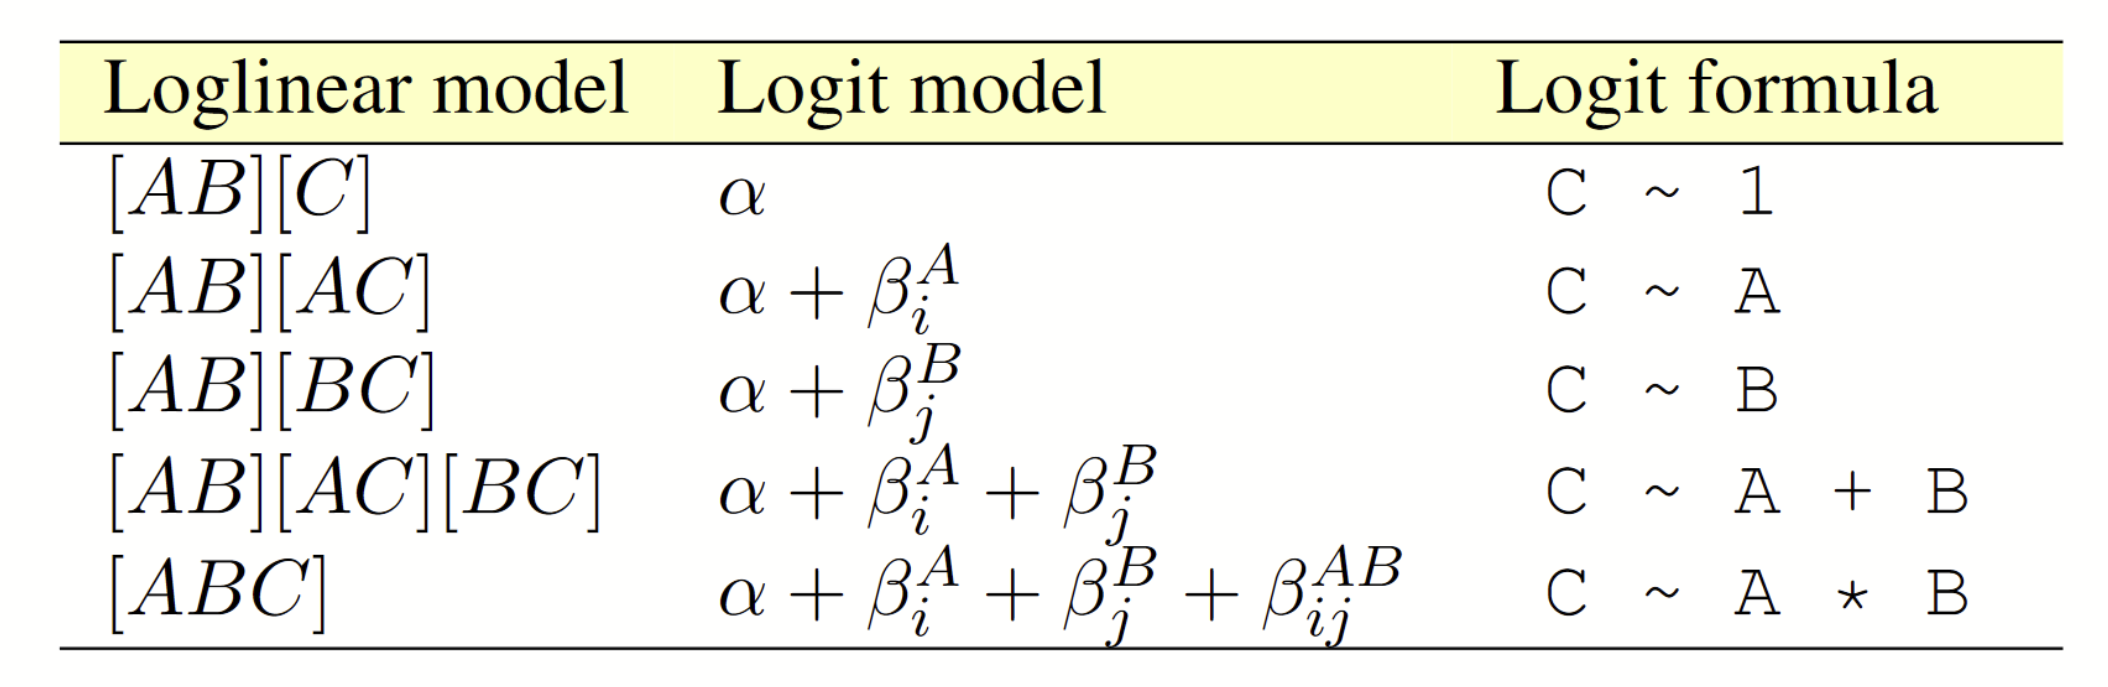

In [79]:
model_logit = smf.logit(formula='Outcome ~ Size', data=imported_data)
results_logit = model_logit.fit()

print(results_logit.summary())

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                    8
Model:                          Logit   Df Residuals:                        6
Method:                           MLE   Df Model:                            1
Date:                Thu, 18 May 2023   Pseudo R-squ.:                   0.000
Time:                        11:56:00   Log-Likelihood:                -5.5452
converged:                       True   LL-Null:                       -5.5452
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept           0      1.000          0      1.000      -1.960       1.960
Size                0      1.

# HWK ENDS HERE.

In [ ]:
!pip install pyreadr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 6.9 MB/s eta 0:00:00


In [ ]:
import pyreadr
import pandas as pd

input_path = "kstones.rda"
output_filename = ""

# load RData file
result = pyreadr.read_r(input_path)

# extract dataframe
print(result)
print(result["Counts"])
df = pd.DataFrame(result)

# save dataframe as CSV file
df.to_csv("111example.csv", index=False)

OrderedDict([('kstones',    Counts   Size Method  Outcome
0      81  Small      A  Success
1       6  Small      A  Failure
2     234  Small      B  Success
3      36  Small      B  Failure
4     192  Large      A  Success
5      71  Large      A  Failure
6      55  Large      B  Success
7      25  Large      B  Failure)])


KeyError: ignored

In [ ]:
# import datasetu (pomoci Pandas)
# (puvodne dataset byl stazen z >>    )
#url = "https://raw.githubusercontent.com/francji1/01RAD/main/data/01RAD2022_house.csv"
#imported_data = pd.read_csv(url)

#imported_data
#data.info

In [ ]:
p_valuee = sm.stats.stattools.chisqprob(chi2_test, dof_ab_ac)

In [ ]:
numbers = [1, 2, 3, 4, 5]
squared_numbers = [x**2 for x in numbers]
print(squared_numbers)

In [ ]:
# perform Pearson's chi-square statistic from the result
chi2_test = results_ab_ac.pearson_chi2
print(chi2_test)

In [ ]:
# obtain degrees of freedom of this model
dof_ab_ac = results_ab_ac.df_resid
print(dof_ab_ac)

In [ ]:
p_value = 1 - scp.stats.chi2.cdf(chi2_test, dof_ab_ac)
print(p_value)

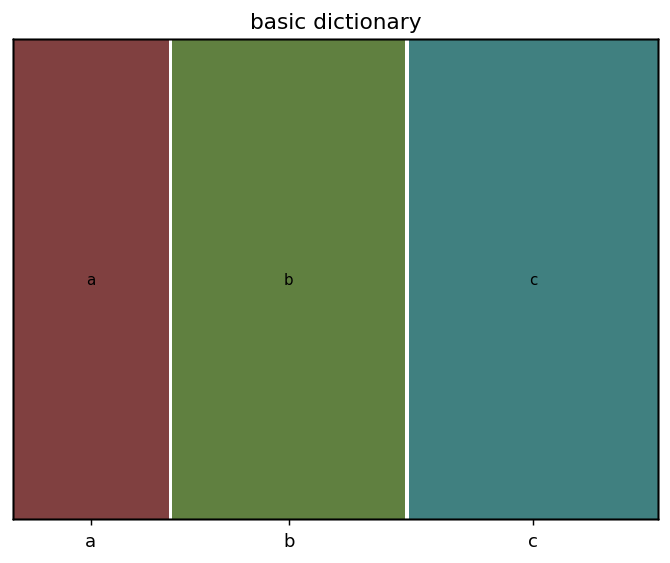

In [ ]:
data = {'a': 10, 'b': 15, 'c': 16}
mosaic(data, title='basic dictionary')
plt.show()

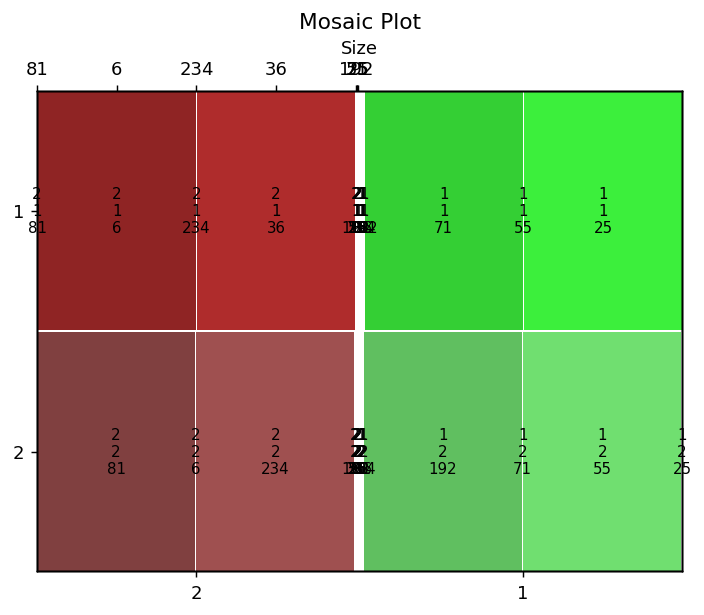

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic

# Create a mosaic plot
mosaic(imported_data, ['Size', 'Outcome', 'Counts'])

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Method')
plt.title('Mosaic Plot')

# Display the plot
plt.show()